In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from os import listdir
import pandas as pd
import albumentations as A
import cv2 as cv
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import concatenate, Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Activation, Concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras import backend as keras
from keras.optimizers import Adam
from keras.models import Model
import segmentation_models as sm

Segmentation Models: using `keras` framework.


([], [])

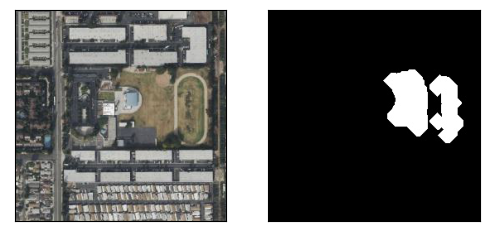

In [2]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread('resized-all/1.jpg'), 'gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
    
plt.subplot(1, 2, 2)
plt.imshow(plt.imread('mask-resized-all/1.jpg'), 'gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
    

In [3]:
# this function lists files from directory
def build_data(TRAIN_PATH, LABEL_PATH):
    train = []
    label = []
    filenames = sorted(listdir(TRAIN_PATH))
    for name in filenames:
        train.append(TRAIN_PATH + '/' + name)
        
    filenames = sorted(listdir(LABEL_PATH))
    for name in filenames:
        label.append(LABEL_PATH + '/' + name)
        
    return train, label

# first with equalized images
eq_sat_image, eq_mask_image = build_data('resized-all', 'mask-resized-all')   

In [4]:
def build_dataframe(SAT_IMAGE, MASK_IMAGE):
    df = pd.DataFrame({
        'Image' : SAT_IMAGE,
        'Mask' : MASK_IMAGE
    })

    return df

In [5]:
# for equalized images
df = build_dataframe(eq_sat_image, eq_mask_image)

In [6]:
df

,Image,Mask
0,resized-all/0.jpg,mask-resized-all/0.jpg
1,resized-all/1.jpg,mask-resized-all/1.jpg
2,resized-all/10.jpg,mask-resized-all/10.jpg
3,resized-all/100.jpg,mask-resized-all/100.jpg
4,resized-all/1000.jpg,mask-resized-all/1000.jpg
...,...,...
2717,resized-all/995.jpg,mask-resized-all/995.jpg
2718,resized-all/996.jpg,mask-resized-all/996.jpg
2719,resized-all/997.jpg,mask-resized-all/997.jpg
2720,resized-all/998.jpg,mask-resized-all/998.jpg


In [7]:
# https://albumentations.ai/docs/getting_started/image_augmentation/
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
    #A.Blur(blur_limit = 5, p = 0.85), 
])

In [8]:
# get sizes for train, validation and test data
def get_sizes(df):
    train_size = int(0.8 * df.shape[0])
    val_size = int(0.2 * df.shape[0])
    test_size = int(0.1 * df.shape[0])

    return train_size, val_size, test_size

In [9]:
print(get_sizes(df), get_sizes(df))

(2177, 544, 272) (2177, 544, 272)


In [11]:
def split_data(df):
    train_size, validation_size, test_size = get_sizes(df)

    X_train, y_mask_train = (df[:train_size], df[:train_size])
    X_validation, y_mask_validation = (df[train_size:train_size+test_size], df[train_size:train_size+test_size])
    X_test, y_mask_test = (df[train_size+test_size:], df[train_size+test_size:])

    return X_train, X_validation, X_test    

In [12]:
# spliting for resized images
X_train, X_validation, X_test = split_data(df)
print(len(X_train), len(X_validation), len(X_test))

2177 272 273


In [13]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

IMG_SIZE = (256, 256)

def modify_mask(mask):
    # (256, 256) -> (256, 256, 1)
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    
    # onde na máscara original for maior que 100, a t_mask vira 1
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

# associa máscara à imagem
def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = cv.resize(img, IMG_SIZE)
    mask = modify_mask(cv.resize(mask, IMG_SIZE))
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [14]:
BATCH_SIZE = 8

# passa como entrada o dataframe
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    
    #(<tf.Tensor: shape=(), dtype=string, numpy=b'train/125.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'train_labels/125.jpg'>)
    
    dataset = dataset.shuffle(1000)

    # aplica uma função a cada elemento do dataset e retorna um novo dataset contendo
    # os elementos transformados
    # nesse caso, chama a função que aplica a função tranformed
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    # This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [15]:
def iter_dataset(X_dataset):
    dataset = create_dataset(X_dataset)
    img, mask = next(iter(dataset))
    print(img.shape, mask.shape)
    return dataset

In [16]:
# create train dataset for resised images
train_dataset = iter_dataset(X_train)

# create validation dataset for resized images
validation_dataset = iter_dataset(X_validation)

(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)


In [17]:
# function to evaluate the dice coef in the unet training
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1.0) 

# function to evaluate the dice coef loss in the unet training
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [18]:
# function to evaluate the dice coef in the test dataframe
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [28]:
# def conv_block(input_tensor, filters, kernel_size=3):
#     x = Conv2D(filters, kernel_size, activation='relu', padding='same')(input_tensor)
#     x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
#     return x

# def unet(input_shape=(256,256,3), num_classes=1):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = conv_block(inputs, 64)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = conv_block(pool1, 128)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = conv_block(pool2, 256)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = conv_block(pool3, 512)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # Center
#     center = conv_block(pool4, 1024)

#     # Decoder
#     up1 = UpSampling2D(size=(2, 2))(center)
#     conv5 = conv_block(up1, 512)

#     merge1 = concatenate([conv4, conv5], axis=3)
#     conv6 = conv_block(merge1, 512)

#     up2 = UpSampling2D(size=(2, 2))(conv6)
#     conv7 = conv_block(up2, 256)

#     merge2 = concatenate([conv3, conv7], axis=3)
#     conv8 = conv_block(merge2, 256)

#     up3 = UpSampling2D(size=(2, 2))(conv8)
#     conv9 = conv_block(up3, 128)

#     merge3 = concatenate([conv2, conv9], axis=3)
#     conv10 = conv_block(merge3, 128)

#     up4 = UpSampling2D(size=(2, 2))(conv10)
#     conv11 = conv_block(up4, 64)

#     merge4 = concatenate([conv1, conv11], axis=3)
#     conv12 = conv_block(merge4, 64)

#     output = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(conv12)

#     return Model(inputs, output)

In [29]:

def unet(input_shape=(256,256,3), num_classes=1):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Center
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(center)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    merge1 = concatenate([conv5, conv6], axis=3)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge1)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    merge2 = concatenate([conv4, conv8], axis=3)
    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge2)
    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv9)

    up3 = UpSampling2D(size=(2, 2))(conv8)
    conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv10)

    merge3 = concatenate([conv3, conv10], axis=3)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge3)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv11)

    up4 = UpSampling2D(size=(2, 2))(conv11)
    conv12 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv12 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv12)

    merge4 = concatenate([conv2, conv12], axis=3)
    conv13 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv13 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv13)
    
    up5 = UpSampling2D(size=(2, 2))(conv13)
    conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv14)

    merge5 = concatenate([conv1, conv14], axis=3)
    conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv15)

    output = Conv2D(num_classes, (1, ), activation='sigmoid', padding='same')(conv15)

    return Model(inputs, output)

In [30]:
# # 8 layers
# def unet(input_shape=(256,256,3), num_classes=1):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # Center
#     center = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
#     center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)

#     # Decoder
#     up1 = UpSampling2D(size=(2, 2))(center)
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

#     merge1 = concatenate([conv4, conv5], axis=3)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge1)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

#     up2 = UpSampling2D(size=(2, 2))(conv6)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

#     merge2 = concatenate([conv3, conv7], axis=3)
#     conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge2)
#     conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

#     up3 = UpSampling2D(size=(2, 2))(conv8)
#     conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
#     conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

#     merge3 = concatenate([conv2, conv9], axis=3)
#     conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge3)
#     conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv10)

#     up4 = UpSampling2D(size=(2, 2))(conv10)
#     conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
#     conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)

#     merge4 = concatenate([conv1, conv11], axis=3)
#     conv12 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
#     conv12 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv12)

#     output = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(conv12)

#     return Model(inputs, output)

In [31]:
model = unet()

In [32]:
print(model)

In [33]:
callbacks = [EarlyStopping(patience=6, monitor='loss')]

In [34]:
model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=["binary_crossentropy", dice_coef_loss],
        metrics=[dice_coef, 'binary_accuracy', sm.metrics.iou_score]
    )

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = validation_dataset, 
    batch_size = 8,
    epochs = 1,
    callbacks = [callbacks]
)